In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import xarray.ufuncs as xu
import matplotlib.pyplot as plt
%matplotlib inline
import cmocean as cm
import dask.array as da
import scipy.io
from scipy import signal
import os
from dask.distributed import Client
client = Client()
client

C:\ProgramData\Anaconda3\envs\estuary\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59215 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:59215/status,
Dashboard: http://127.0.0.1:59215/status,Workers: 4
Total threads: 16,Total memory: 63.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59216,Workers: 4
Dashboard: http://127.0.0.1:59215/status,Total threads: 16
Started: Just now,Total memory: 63.20 GiB
Comm: tcp://127.0.0.1:59252,Total threads: 4
Dashboard: http://127.0.0.1:59253/status,Memory: 15.80 GiB
Nanny: tcp://127.0.0.1:59222,


In [ ]:
# url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/users/scook/proj/DE_Bay/run07/run07C/ocean_deb_his_run07C_tsvar_00010.nc'
# ds = xr.open_dataset(url, chunks={'ocean_time':1})
# ds

### import locally (decrease computation time)

In [82]:
path = 'salt.nc'
ds = xr.open_dataset(path, chunks={'ocean_time':1})
dist_mile = xr.DataArray(dist_mile,dims=['points'])
ds = xr.Dataset(ds, coords={'dist_mile': dist_mile})
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, points: 1370, s_rho: 16)
Coordinates:
  * s_rho       (s_rho) float64 -0.9688 -0.9062 -0.8438 ... -0.09375 -0.03125
    lon_rho     (points) float64 dask.array<chunksize=(1370,), meta=np.ndarray>
    lat_rho     (points) float64 dask.array<chunksize=(1370,), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2019-09-28T01:00:00 ... 2019-10-28
    dist_mile   (points) float64 -6.864 -6.737 -6.609 ... 134.2 134.3 134.5
Dimensions without coordinates: points
Data variables:
    salt        (ocean_time, s_rho, points) float32 dask.array<chunksize=(1, 16, 1370), meta=np.ndarray>

In [83]:
river_mile_coords = pd.read_csv('01_fetch/src/river_mile_coords.csv', index_col=0 )
target_x = np.array(river_mile_coords.iloc[:,[1]].values).squeeze()
target_x = xr.DataArray(target_x, dims=["dist_miles"]) 
target_y = np.array(river_mile_coords.iloc[:,[2]].values).squeeze()
target_y = xr.DataArray(target_y,dims=["dist_miles"])

In [84]:
dist_mile = np.array(river_mile_coords.iloc[:,[0]].values)
dist_mile = dist_mile.squeeze()
dist_mile = xr.DataArray(dist_mile,dims=['points']) #change to points
dist_mile = dist_mile.values
dist_mile

array([ -6.86446808,  -6.73695053,  -6.60944252, ..., 134.16375535,
       134.32597435, 134.48806645])

In [ ]:
salt = ds['salt'].isel(xi_rho=target_x,eta_rho=target_y) 

In [86]:
salt = salt.salt
salt = salt.isel(s_rho=0)
# salt = salt.sortby(dist_mile)

In [87]:
salt

<xarray.DataArray 'salt' (ocean_time: 720, points: 1370)>
dask.array<getitem, shape=(720, 1370), dtype=float32, chunksize=(1, 1370), chunktype=numpy.ndarray>
Coordinates:
    s_rho       float64 -0.9688
    lon_rho     (points) float64 dask.array<chunksize=(1370,), meta=np.ndarray>
    lat_rho     (points) float64 dask.array<chunksize=(1370,), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2019-09-28T01:00:00 ... 2019-10-28
    dist_mile   (points) float64 -6.864 -6.737 -6.609 ... 134.2 134.3 134.5
Dimensions without coordinates: points
Attributes:
    long_name:  salinity
    time:       ocean_time
    grid:       grid
    location:   face
    field:      salinity, scalar, series

In [ ]:
# salt_test = salt.to_dataframe()
# salt_test

In [88]:
saltfront = salt.where(salt < 0.52).where(salt > 0.51)
# salfront_values = saltfront.where(saltfront.max('points'))
# saltfront_values.to_dataframe()

In [89]:
saltfront_location = saltfront.where(saltfront.max('ocean_time'))

In [90]:
# saltfront_location= saltfront.to_dataframe()
saltfront_location= saltfront_location.to_dataframe()
saltfront_location

s_rho    lon_rho    lat_rho   dist_mile  salt
ocean_time          points                                                 
2019-09-28 01:00:00 0      -0.96875 -74.898547  38.709599   -6.864468   NaN
                    1      -0.96875 -74.901000  38.711905   -6.736951   NaN
                    2      -0.96875 -74.903454  38.714211   -6.609443   NaN
                    3      -0.96875 -74.902944  38.718438   -6.212644   NaN
                    4      -0.96875 -74.905398  38.720744   -6.085149   NaN
...                             ...        ...        ...         ...   ...
2019-10-28 00:00:00 1365   -0.96875 -74.773592  40.216001  133.845539   NaN
                    1366   -0.96875 -74.775092  40.217801  134.001409   NaN
                    1367   -0.96875 -74.776592  40.219601  134.163755   NaN
                    1368   -0.96875 -74.778092  40.221401  134.325974   NaN
                    1369   -0.96875 -74.779592  40.223201  134.488066   NaN

[986400 rows x 5 columns]

In [91]:
df = saltfront_location[saltfront_location['salt'].notna()]
df = df.droplevel(level=1)
df

,s_rho,lon_rho,lat_rho,dist_mile,salt
ocean_time,,,,,
2019-09-28 02:00:00,-0.96875,-75.409034,39.807939,79.185240,0.514313
2019-09-28 02:00:00,-0.96875,-75.408179,39.808519,79.251298,0.512174
2019-09-28 03:00:00,-0.96875,-75.386823,39.820431,80.794789,0.516436
2019-09-28 04:00:00,-0.96875,-75.347027,39.842247,83.647922,0.519163
2019-09-28 04:00:00,-0.96875,-75.345878,39.842702,83.721712,0.514050
...,...,...,...,...,...
2019-10-27 19:00:00,-0.96875,-75.333459,39.847749,84.483010,0.517190
2019-10-27 20:00:00,-0.96875,-75.371609,39.828046,81.858909,0.512234
2019-10-27 21:00:00,-0.96875,-75.399804,39.809850,79.710148,0.517799


In [92]:
df = df.resample('1D').mean()
# salt_daily = saltfront_location.groupby('ocean_time.day').mean('ocean_time')
# salt_daily = salt_daily.to_dataframe()
df

,s_rho,lon_rho,lat_rho,dist_mile,salt
ocean_time,,,,,
2019-09-28,-0.96875,-75.383521,39.820588,80.952996,0.514530
2019-09-29,-0.96875,-75.375344,39.824451,81.512187,0.515184
2019-09-30,-0.96875,-75.359667,39.827045,82.412903,0.515213
2019-10-01,-0.96875,-75.345774,39.831598,83.283082,0.514956
2019-10-02,-0.96875,-75.357283,39.829902,82.628774,0.514394
2019-10-03,-0.96875,-75.354388,39.830434,82.800818,0.515585
2019-10-04,-0.96875,-75.299376,39.844502,86.100251,0.514963
2019-10-05,-0.96875,-75.319249,39.840083,84.939771,0.514766
2019-10-06,-0.96875,-75.323028,39.840144,84.751451,0.515470


<AxesSubplot:xlabel='ocean_time'>

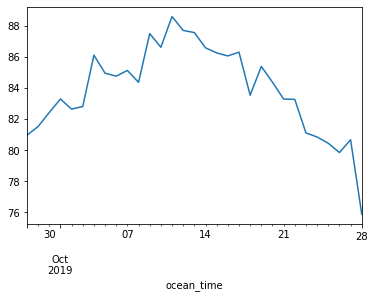

In [54]:
df['dist_mile'].plot()

In [55]:
df.columns

Index(['s_rho', 'lon_rho', 'lat_rho', 'dist_mile', 'salt'], dtype='object')

In [93]:
df.index = pd.to_datetime(df.index)

In [94]:
df

,s_rho,lon_rho,lat_rho,dist_mile,salt
ocean_time,,,,,
2019-09-28,-0.96875,-75.383521,39.820588,80.952996,0.514530
2019-09-29,-0.96875,-75.375344,39.824451,81.512187,0.515184
2019-09-30,-0.96875,-75.359667,39.827045,82.412903,0.515213
2019-10-01,-0.96875,-75.345774,39.831598,83.283082,0.514956
2019-10-02,-0.96875,-75.357283,39.829902,82.628774,0.514394
2019-10-03,-0.96875,-75.354388,39.830434,82.800818,0.515585
2019-10-04,-0.96875,-75.299376,39.844502,86.100251,0.514963
2019-10-05,-0.96875,-75.319249,39.840083,84.939771,0.514766
2019-10-06,-0.96875,-75.323028,39.840144,84.751451,0.515470
